### Learn a differential equation 

* $f(x) = \frac{dx}{dt}$

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable 
import torch.nn.functional as F

%matplotlib inline 

### Set up the data: 

We want to set up a system where the network takes in some random vector $\mathbf{z}$ with the initial $t$ values  and learns the $x$ s.t. that $x$ is the solution to $f(x)=\frac{dx}{dt}$

* $\frac{dx}{dt} = 5x-3$
* Solution: $x(t) = Ce^{5t}+\frac{3}{5}$

In [2]:
np.random.seed(1)

# Function
f = lambda x: 5.0*x-3.0
x_func = lambda x: 2./5.*np.exp(5.*(t-2.))+3./5.

# Params
n_examples = 10000
z_size = 10

# Set up the data 
x_real = np.random.normal(loc=0.0,scale=10,size=n_examples)
fx_real = f(x_real).reshape(-1,1)
t = np.random.uniform(-20,20,size=n_examples).reshape(-1,1,1)
z = np.random.randn(n_examples,1,z_size)
inpt = np.append(t,z,axis=2)

# Test the t element is where we think it is 
assert(all(t.ravel()==inpt[:,:,0].ravel()))

### How should we set up the x and t relationship?

It doesn't look like there is much of a signal, but that can be mispecification or just me not doing the right stuff. 

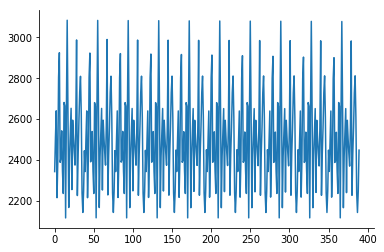

In [3]:
class XGen(nn.Module):
    """ Generative model for the X values s.t. they solve dx/dt = f(x) """
    def __init__(self, indim):
        super(XGen,self).__init__()
        self.deconv1 = nn.ConvTranspose1d(1,10,kernel_size=1)
        self.bn1 = nn.BatchNorm1d(10)
        self.deconv2 = nn.ConvTranspose1d(10,10,kernel_size=2)
        self.bn2 = nn.BatchNorm1d(10)
        self.deconv3 = nn.ConvTranspose1d(10,20,kernel_size=2)
        self.bn3 = nn.BatchNorm1d(20)
        self.linear = nn.Linear(20*(indim+2),1)
        
    def forward(self,x):
        x = F.leaky_relu(self.deconv1(x),0.05)
        x = self.bn1(x)
        x = F.leaky_relu(self.deconv2(x),0.05)
        x = self.bn2(x)
        x = F.leaky_relu(self.deconv3(x),0.05)
        x = self.bn3(x)
        x = self.linear(x.view(x.size(0),-1))
        return x
    
def dxdt(x,t):
    """ Use a 1D conv to take the partial derivative dx/dt """
    var_x = x.view(1,1,-1)
    var_t = t.view(1,1,-1)
    weights = Variable(torch.Tensor([1,-1]).view(1,1,-1))
    deriv = torch.div(F.conv1d(F.pad(var_x,(0,1)),weights), F.conv1d(F.pad(var_t,(0,1)),weights))
    return deriv.view(-1,1)

def train(net, opt, loss_func, z_in, t_in, fx_in, epochs=10, bs=256):
    """ Train the model """
    losses,itr = [],0
    nbatches = int(len(t_in)/bs)
    z_tensor = torch.Tensor(z_in)
    t_tensor = torch.Tensor(t_in)
    fx_tensor = torch.Tensor(fx_in)
    
    for e in range(epochs):
        for b in range(nbatches):
            z_batch = Variable(z_tensor.narrow(0,b*bs,bs))
            t_batch = Variable(t_tensor.narrow(0,b*bs,bs))
            fx_batch = Variable(fx_tensor.narrow(0,b*bs,bs))
            opt.zero_grad()
            
            x_est = net(z_batch)
            fx_est = dxdt(x_est,t_batch)
            loss = loss_func(fx_est,fx_batch)
            
            loss.backward()
            opt.step()
            
            itr+=1
            losses.append(loss)
            
    return range(itr),[i.data.numpy()[0] for i in losses]
            
            
# Set up model      
net = XGen(z_size+1)
opt = optim.SGD(net.parameters(),lr=0.0001)
loss_func = nn.MSELoss()

# Train the model 
itr, losses = train(net,opt,loss_func,inpt,t,fx_real)

# Look at plot of loss 
plt.plot(itr,losses)
sns.despine()

In [4]:
# Verifications

# Verify conv FD setup is right 
xx = torch.Tensor([2,3,4,5,6,7,8,8.1,8.2])
ff = torch.pow(xx,2)
for i in range(xx.size(0)-1):
    aa = (ff[i]-ff[i+1])/(xx[i]-xx[i+1])
    print(aa)

ff_re = Variable(ff.view(1,1,-1))
xx_re = Variable(xx.view(1,1,-1))

weights = torch.Tensor([1,-1]).view(1,1,-1)
num = F.conv1d(ff_re,Variable(weights))
den = F.conv1d(xx_re,Variable(weights))
num/den

5.0
7.0
9.0
11.0
13.0
15.0
16.100020980754927
16.299989509522494


Variable containing:
(0 ,.,.) = 
   5.0000   7.0000   9.0000  11.0000  13.0000  15.0000  16.1000  16.3000
[torch.FloatTensor of size 1x1x8]